<a href="https://colab.research.google.com/github/anasistac/AUC_TM_2025/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2

## Guidelines

> Remember that this is a code notebook - add an explanation of what you do using text boxes and markdown, and comment your code. Answers without explanations may get less points.
>
> If you re-use a substantial portion of code you find online, e.g on Stackoverflow, you need to add a link to it and make the borrowing explicit. The same applies of you take it and modify it, even substantially. There is nothing bad in doing that, providing you are acknowledging it and make it clear you know what you're doing.
>
> The **Generative AI policy** from the syllabus for the programming assignments applies. Generative AI can be used as a source of information in these assignments if properly referenced. You can use generative AI assistance for writing code, but you must reference the chat used as a source, just as if you would take from StackOverflow. In ChatGPT, you can make an URL to the information you obtained by clicking the "Share link to Chat" button and then "Copy Link". This allows you to cite the source of the information you use in your answer or code solution. Of course, as you know, GenAI tools are not always a reliable source and its answers are intransparantly drawn from other sources - it is recommended to cross-check its output with other sources or your own understanding of the topic.
>
> For the explanations of what you do that you provide with each question, as well as for (sub)questions that ask about things like motivation of choices or your opinion, the answer to this must be conceptualized and written by yourself and not copied from a generative AI source.
>
> Make sure your notebooks have been run when you submit, as I won't run them myself. Submit both the `.ipynb` file along with an `.html` export of the same. Submit all necessary auxilliary files as well. Please compress your submission into a `.zip` archive. Only `.zip` files can be submitted.
> If you are using Google Colab, here is a tutorial for obtaining an HTML export: https://stackoverflow.com/questions/53460051/convert-ipynb-notebook-to-html-in-google-colab .
>
> With Jupyter, you can simply export it as HTML through the File menu.

## Grading policy
> As follows:
>
> * 70 points for correctly completing the assignment.
>
> * 20 points for appropriately writing and organizing your code in terms of structure, readibility (also by humans), comments and minimal documentation. It is important to be concise but also to explain what you did and why, when not obvious. Feel free to re-use functions and variables from previous questions if that helps for structure and readability - you do not need to repeat previous steps for each question.
>
> * 10 points for doing something extra, e.g., if you go beyond expectations (overall or on something specific). Some ideas for extras might be mentioned in the exercises, or you can come up with your own. You don't need to do them all to get the bonus. The sum of points is 90, doing (some of) the extras can bring you to 100, so the extras are not necessary to get an A.
>

**The AUC code of conduct applies to this assignment: please only submit your own work and follow the instructions on referencing external sources above.**

---

# Introduction

In this assignment, you will build and compare vector models for measuring **semantic similarity**.

First, you are going to use different count-based methods to create these models. Secondly you are going to created dense, lower-dimensionality models from them. Thirdly, you are going to use prediction-based models as well.

Eventually, you are asked to assess the performance of these models against a human gold standard.

I recommend basing your code on the examples in the course notebooks on this topic.

---

# Corpus preparation (8 points)

## Question 1 (8 points)

Prepare for creating a distributional space by **counting and filtering** the surface co-occurrences in a symmetric ±5 word collocations span from the following corpus:

* A lemmatized version of the Reuters corpus (the choice of the lemmatizer is up to you). For this step, you might need a PoS-tagger: you are welcome to choose one yourself. In case you can't do PoS tagging on your own, you can use the following command to load the provided corpus in `data/reuters.pos` (uploaded as a `.zip` file, so first unzip it):

```python
with open("data/reuters.pos", "rb") as corpus_file:
    reuter_PoSTagged = pickle.load(corpus_file)
```

Remember to make motivated choices for the different strategies in building word vectors as described in class. Be explicit about:

1. what lemmas you want to describe (i.e., what will be your target vectors?);
2. how you want to describe them (i.e., what will be your contexts?);
3. what filtering strategy you are going to choose (i.e., what do you exclude?).

That means you should describe these things in text.

**Possible extra**

Actually create the space with these counts as values (i.e. make a vector with the counts, as in the subsequent questions where we put weighted counts in the vector).

In [ ]:
# 1- we need to load the data
import pickle
import pandas as pd

with open("data/reuters.pos", "rb") as corpus_file:
    reuters_tagged = pickle.load(corpus_file)

# 2- we need to normalize and tokenize the data: convert to lowercase, remove the punctuation and only keep the content words

from collections import Counter

# define the tags of the content words we want to keep
content_pos_tags = {'NN', 'NNS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'JJ', 'RB'}

# normalize and collect the frequency of each lemma
normalized_corpus = []
lemma_freq = Counter() # count frequencies of each lemma

for sentence in reuters_tagged:
    clean_sentence = []
    for lemma, pos in sentence:
        lemma = lemma.lower() # convert to lowercase
        # remove punctuation and keep only content words
        if lemma.isalpha() and pos in content_pos_tags:
            clean_sentence.append((lemma, pos))
            lemma_freq[lemma] += 1
    normalized_corpus.append(clean_sentence)

# 3- count the co-occurrences (5 word window)
from collections import defaultdict

window_size = 5
min_freq = 100 # filter out rare words

# select the words that occur at least min_freq=100 times
vocab = {lemma for lemma, freq in lemma_freq.items() if freq >= min_freq}

# create a dictionary to store the co-occurrences
co_occurrences = defaultdict(Counter)

# loop through the sentences and count co-occurrences with context words
for sentence in normalized_corpus:
    for i, (target, pos) in enumerate(sentence):
        if target not in vocab:
            continue
        start = max(0, i - window_size)
        end = min(len(sentence), i + window_size + 1)

        for j in range(start, end):
            if i == j:
                continue # skip target word itself
            context, context_pos = sentence[j]
            if context in vocab:
                co_occurrences[target][context] += 1

# 4- BONUS: create co-occurrence matrix

# collect all contexts and their frequencies
all_contexts = Counter()
for contexts in co_occurrences.values():
    all_contexts.update(contexts)

# get the 5000 most common words
top_contexts = {context for context, freq in all_contexts.most_common(5000)}

# create rows for the matrix: each row is a target word and its context counts
rows = []
for target in co_occurrences:
    row_data = {'__target__': target}
    for context in top_contexts:
        count = co_occurrences[target][context]
        if count > 0:
            row_data[context] = count
    rows.append(row_data)

# create the DataFrame
co_occurrence_df = pd.DataFrame(rows).fillna(0).set_index('__target__')
print(co_occurrence_df.head())

            coffee  normal  sells  canadian  situation  production  \
__target__                                                           
damage         2.0     2.0    1.0       3.0        2.0         4.0   
trade         24.0     2.0    1.0      22.0       10.0         6.0   
s            115.0     9.0   26.0     146.0       27.0       258.0   
has           42.0     9.0   27.0      24.0       17.0        73.0   
raised         0.0     1.0    0.0       4.0        1.0         3.0   

            government  special  substantial  proposal  ...  profits  buyout  \
__target__                                              ...                    
damage             1.0      1.0          5.0       1.0  ...      0.0     0.0   
trade             62.0      7.0          7.0       8.0  ...      0.0     0.0   
s                419.0     49.0         25.0     112.0  ...     84.0    16.0   
has              142.0     20.0         14.0      35.0  ...     10.0    13.0   
raised             7.0      0

In this task, I created a co-occurrence matrix from the reuters corpus following these steps:

1. Target words: I chose all the content words (nouns, verbs, adjectives and adverbs) that occur at least 100 times in the corpus. Specifically, I included lemmas tagged with the POS tags: NN, NNS, VB, JJ, RB... These become the target words, which later are the rows of the matrix.

2. Context words: I used this same set of content words as possible context words (which are the columns in the matrix). They are extracted within a 5 word symmetric window of the target word. I only considered context words that also occur frequently in the corpus (top 5000 by frequency).

3. Filtering criteria: all the lemmas are converted to lowercase; I excluded punctuation, digit and all non-alphabetic tokens. I also removed low frequency words (those with <100 occurrences) to reduce noise, and limited the vocabulary to only the top 5000 most frequent words.

The final output is a DataFrame, where each row vector corresponds to a target word and contains the co-occurrence counts with frequent context words.

---

# Vector representations (45 points)

## Question 2 (15 points)

Weight the counts in the space you created for the previous question by using the following association measures on both spaces:

1. One **measure of your choice** among those available in the [nltk.BigramAssocMeasures](http://www.nltk.org/howto/metrics.html#association-measures) module.
2. The **Positive Local Mutual Information** measure (as shown in class/lab).

**Possible extra**

3. Also use the **smoothed ppmi measure** proposed by [Levy et al. (2015)](http://www.aclweb.org/anthology/Q15-1016). Recall that the authors proposed to smooth the ppmi by raising the context counts to the power of $\alpha$ (where $\alpha= 0.75$ is reported to work well). That is, if $V_c$ is the vocabulary of all the contexts in a given space and $f(c)$ is the context frequency, they proposed the following association measure:

$$PPMI_\alpha (w,c) = max \left(0, \ log_2 \left(\frac{p(w,c)}{p(w) \cdot p_\alpha(c)}\right)  \right) $$

$$where: \ \ p_\alpha(c) = \frac{f(c)^\alpha}{\sum_{c' \in V_c} f(c')^\alpha}$$

In [ ]:
from nltk.collocations import BigramAssocMeasures
import numpy as np
import pandas as pd

X_counts = co_occurrence_df  # our co-occurrence matrix

bam = BigramAssocMeasures() # to calculate statistical measures

# get frequencies
N = X_counts.values.sum()    # total number of co-occurrences
f_w = X_counts.sum(axis=1)   # occurrences of each word (row)
f_c = X_counts.sum(axis=0)   # occurrences of each context (column)

# initialize new empty matrix of same shape as the original to store PMI values
pmi_df = pd.DataFrame(index=X_counts.index, columns=X_counts.columns)

# double loop over every (target, context) pair in the co-occurrence matrix
for w in X_counts.index:
    for c in X_counts.columns:
        f_wc = X_counts.at[w, c]
        if f_wc == 0: # if the pair never co-occurred, set PMI to 0
            pmi_df.at[w, c] = 0
            continue
        n_w = f_w[w] # compute PMI using NLTK's formula
        n_c = f_c[c]
        pmi = bam.pmi(int(f_wc), (int(n_w), int(n_c)), int(N))
        pmi_df.at[w, c] = max(0, pmi)  # convert to positive PMI, which is PPMI

pmi_df.iloc[:10, :10]

,coffee,normal,sells,canadian,situation,production,government,special,substantial,proposal
__target__,,,,,,,,,,
damage,1.749543,3.556651,2.604188,2.241087,3.145081,1.19779,0,1.314844,4.480089,0.860614
trade,0.896424,0,0,0.677475,1.028928,0,0.630917,0,0.527434,0
s,0.557035,0,0.266628,0.80795,0,0.171018,0.78761,0,0,0.62997
has,0.750853,0.335568,1.968067,0,0.841537,0,0.873542,0.245764,0.574508,0.59889
raised,0,0.626491,0,0.725964,0.214921,0,0,0,0.228001,0
many,0.830971,0,0,0,0,0.694255,0.19623,0,0,0
nations,1.398012,0,0,0,0.208587,0,0,0.378349,1.221667,0
far,0.282137,1.089244,0,0.773681,0,0,0.647396,0,0,0
economic,0,0,0,0,3.205259,0,1.940515,0,1.633376,0


To weight the co-occurrence matrix, I chose PMI. It highlights word-context pairs that occur more often than expected by chance, which is useful for capturing relevant associations. Then I applied PPMI by setting negative values to 0 to reduce noise and focus on informative co-occurrences.
The code loops over each target-context pair, retrieves their co-occurrence and marginal frequencies, and computes the PMI score using NLTK’s built-in function. The result is a new matrix where each value reflects how unexpectedly often two words co-occur. Observing the results of the matrix, the output makes sense since, for instance, we can see a high score of 4.6 between the words "damage" and "weather" However, we can see the value 0 when it comes to the relation between the words "trade" and "weather", meaning either they did not co-occur (most likely in my opinion), or they did not co-occur more than expected.

In [ ]:
# Probabilities
# joint probability p(w, c)
p_wc = X_counts / N
# marginal probabilities p(w) and p(c)
p_w = f_w / N
p_c = f_c / N

# compute denominator for each pair using outer product
denom = np.outer(p_w, p_c)
# compute PMI using formula shown by exercise
pmi_matrix = np.log2(p_wc / denom)

# replace invalid values with 0 and clip all negative values to 0
pmi_matrix = np.nan_to_num(pmi_matrix, nan=0.0, neginf=0.0)
pmi_matrix = np.maximum(pmi_matrix, 0)

# multiply PPMI * count f(w, c) to get PLMI
plmi_matrix = pmi_matrix * X_counts.values

# convert to DataFrame
plmi_df = pd.DataFrame(plmi_matrix, index=X_counts.index, columns=X_counts.columns)

plmi_df.iloc[:10, :10]

c:\Users\anasi\anaconda\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


,coffee,normal,sells,canadian,situation,production,government,special,substantial,proposal
__target__,,,,,,,,,,
damage,3.499087,7.113302,2.604188,6.723262,6.290163,4.791160,0.000000,1.314844,22.400447,0.860614
trade,21.514179,0.000000,0.000000,14.904440,10.289277,0.000000,39.116869,0.000000,3.692041,0.000000
s,64.058985,0.000000,6.932340,117.960768,0.000000,44.122753,330.008730,0.000000,0.000000,70.556688
has,31.535831,3.020114,53.137818,0.000000,14.306121,0.000000,124.042981,4.915281,8.043118,20.961137
raised,0.000000,0.626491,0.000000,2.903858,0.214921,0.000000,0.000000,0.000000,0.228001,0.000000
many,2.492913,0.000000,0.000000,0.000000,0.000000,5.554041,1.177382,0.000000,0.000000,0.000000
nations,8.388070,0.000000,0.000000,0.000000,0.208587,0.000000,0.000000,0.756699,2.443334,0.000000
far,0.564273,1.089244,0.000000,2.321042,0.000000,0.000000,5.179168,0.000000,0.000000,0.000000
economic,0.000000,0.000000,0.000000,0.000000,48.078879,0.000000,98.966247,0.000000,8.166880,0.000000


In this part I computed the PLMI, which measures the weights of each of the word pairs keeping in mind how informative they are and its frequency. PLMI not only captures how strong the association between two words is but also how reliable the association is based on how often it occurs.
To compute the PLMI I first computed the joint and marginal probabilities of each pair (word, context), used it to calculate the PPMI of each pair and multiplied the PPMI values by the corresponding co-occurrence counts to get the PLMI scores. Now the matrix reflects both the strength and frequency of the associations between words and their contexts. For instance, the words "has" and "said" with a rate of 1341.27 shows the words are very frequent and semantically related, in comparison to "damage" and "weather" which is much less frequent than others

In [ ]:
# EXTRA

alpha = 0.75

# Smoothed context probability
f_c_alpha = f_c ** alpha
p_c_alpha = f_c_alpha / f_c_alpha.sum()

# Outer product of p(w) and p(c)^alpha
denom_smooth = np.outer(p_w, p_c_alpha)

# Smoothed PMI
smoothed_ppmi_matrix = np.log2(p_wc / denom_smooth)
smoothed_ppmi_matrix = np.nan_to_num(smoothed_ppmi_matrix, nan=0.0, neginf=0.0)
smoothed_ppmi_matrix = np.maximum(smoothed_ppmi_matrix, 0)

smoothed_ppmi_df = pd.DataFrame(smoothed_ppmi_matrix, index=X_counts.index, columns=X_counts.columns)

smoothed_ppmi_df.iloc[:10, :10]

c:\Users\anasi\anaconda\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


,coffee,normal,sells,canadian,situation,production,government,special,substantial,proposal
__target__,,,,,,,,,,
damage,1.524641,2.879971,1.915624,2.039539,2.571294,1.360826,0.000000,0.948616,3.903032,0.607944
trade,0.671521,0.000000,0.000000,0.475926,0.455140,0.000000,0.814700,0.000000,0.000000,0.000000
s,0.332132,0.000000,0.000000,0.606402,0.000000,0.334054,0.971393,0.000000,0.000000,0.377300
has,0.525950,0.000000,1.279503,0.000000,0.267749,0.159642,1.057324,0.000000,0.000000,0.346219
raised,0.000000,0.000000,0.000000,0.524416,0.000000,0.000000,0.175780,0.000000,0.000000,0.000000
many,0.606068,0.000000,0.000000,0.000000,0.000000,0.857291,0.380013,0.000000,0.000000,0.000000
nations,1.173109,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012121,0.644610,0.000000
far,0.057234,0.412564,0.000000,0.572132,0.000000,0.000000,0.831178,0.000000,0.000000,0.000000
economic,0.000000,0.000000,0.000000,0.000000,2.631471,0.000000,2.124297,0.000000,1.056319,0.000000


I implemented smoothed PPMI, which reduces the influence of high-frequency context words by raising their frequencies to the power of alpha=0.75. I first adjusted the context probabilities, used them to compute PMI and finally clipped negative values to obtain the smoothed PPMI. The matrix still captures strong associations, but in a more managed way. For instance, "damage" and "weather" remains a strong pair, while some pairs that involve very frequent words like "said" had very low PPMI (near 0) and now seem boosted, which might be due to the change of frequency ratios when smoothing.

## Question 3 (15 points)

Up to this point, you should have created 2 different distributional spaces (4 if you did the extras).

Use **Singular Value Decomposition** to reduce their dimensionality retaining only the first 100 dimensions. For this question, you can either re-use the SVD code from the lab, or import the SVD functions from external libraries such as [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) or [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.svd.html).

**Possible extra**

Find the 'optimal' number of dimensions to retain using the approach shown in the lab. Use a model with this dimensionality instead of 100.

In [ ]:
from sklearn.decomposition import TruncatedSVD
import pandas as pd

# Reduce smoothed PPMI
svd_100 = TruncatedSVD(n_components=100, random_state=42) # reduce smoothed PPMI to 100 dimensions
space_1_reduced = svd_100.fit_transform(smoothed_ppmi_df) # apply SVD to smoothed PPMI matrix
space_1_reduced_df = pd.DataFrame(space_1_reduced, index=smoothed_ppmi_df.index) # output in DataFrame

# Reduce PLMI, same steps as above
space_2_reduced = svd_100.fit_transform(plmi_df)
space_2_reduced_df = pd.DataFrame(space_2_reduced, index=plmi_df.index)


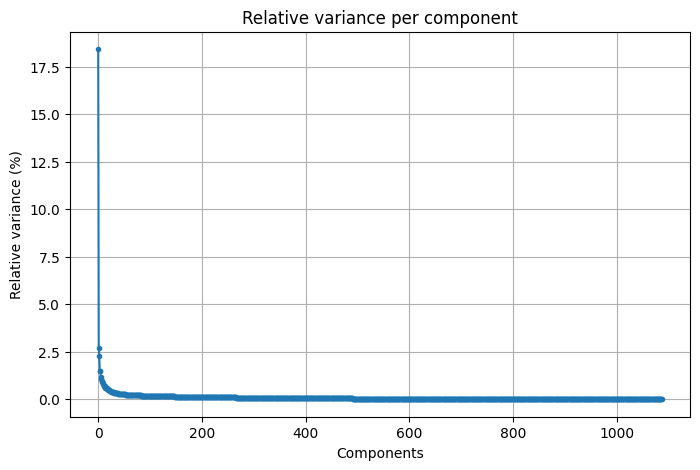

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1. convert DataFrame to matrix
X = smoothed_ppmi_df.values

# 2. compute SVD
U, s, Vt = np.linalg.svd(X, full_matrices=False)

# 3. compute relative variance
rel_variance = (s**2 / np.sum(s**2)) * 100  # variance per component

# plot variance explained by each singular value
plt.figure(figsize=(8, 5))
plt.plot(np.arange(len(rel_variance)), rel_variance, linestyle='-', marker='.')
plt.xlabel("Components")
plt.ylabel("Relative variance (%)")
plt.title("Relative variance per component")
plt.grid(True)
plt.show()


I used SVD to reduce the size of the smoothed PPMI and PLMI word spaces, keeping only the first 100 dimensions. This helps keep the important meaning-related information while making the data smaller and easier to work with.

As an extra step, I also looked at how much information each component keeps. The plot shows that the first few components carry most of the information, and after around 300 components, adding more doesn't help much.

Based on the variance plot, I would select between 150 and 200 components as a more optimal dimensionality, since they retain over 90% of the total variance. I would use this number instead of 100 for a better information preservation.

## Question 4 (15 points)

Train a Word2Vec model the same corpus, for example using [gensim](https://radimrehurek.com/gensim). Make sure to motivate the choice of your hyperparameters.

**Possible extra**

*Hyperparameter tuning* is the process of finding the optimal hyperparameters in a machine learning task for a given task and data set. Try performing some kind of hyperparameter tuning on your Word2Vec model. Hint: Do this after question 5, so that you'll have a way to know what hyperparameter combination is best.

In [ ]:
from gensim.models import Word2Vec

# Extract the lemmas from the Reuters corpus, gives list of tokenized sentences
tokenized_sentences = [
    [lemma for lemma, _ in sentence]
    for sentence in normalized_corpus
]

# Create the Word2Vec model, these are the parameters we will use:
vector_size = 100
window = 5
min_count = 5
workers = 4
sg = 1
epochs = 10

# Train model
w2v_model = Word2Vec(
    sentences=tokenized_sentences,
    vector_size=vector_size,
    window=window,
    min_count=min_count,
    workers=workers,
    sg=sg,
    epochs=epochs
)
word_vectors = w2v_model.wv

# Showing an example word and its vector
print(word_vectors['trade'])
print(word_vectors.most_similar('trade')) # 10 most similar words


[-0.0027309  -0.23015895  0.06490087 -0.09119755  0.41850907 -0.1405846
 -0.07357531  0.6435993  -0.1137935   0.23384392 -0.47688642  0.42760366
  0.10748001  0.37605035  0.54799885  0.4751889   0.40182313 -0.7304714
  0.17948683 -0.19387305  0.3788905  -0.04948162 -0.44838205 -0.15836573
 -0.68925077  0.37032694  0.02087655  0.05541996 -0.0564388   0.6071618
  0.67176867  0.4548308  -0.52643126 -0.8874347  -0.33356878 -0.22613895
  0.3145475   0.1849813  -0.6066289  -0.25344     0.42154318  0.38592744
  0.13599543 -0.46362475  0.33251035  0.1575175  -0.20646788 -0.338457
  0.5258978   0.26241127 -0.03505587 -0.3595145  -0.07609449  0.31590527
 -0.01527201  0.32237622  0.11405778  0.7320819  -0.02214464  0.05012696
 -0.34339246 -0.370626   -0.42139286  0.3072423   0.04431188  0.2920223
  0.23481877  0.15930411  0.367581    0.5586009  -0.12042721  0.15778694
 -0.3006362  -0.10538536  0.35072356 -0.33996445 -0.00934026 -0.15230156
 -0.14036144 -0.13443537 -0.5893047  -0.21698286 -0.34961

I trained the Word2Vec model with these hyperparameters:

- vector_size=100: number of dimensions for each word vector. I chose 100 because it's a common size that gives good results and keeps the model efficient.

- window=5: how many words before and after the target word are considered as context. I used 5 to match the window used in my previous models.

- min_count=5: means the model ignores words that appear fewer than 5 times in the corpus. Reduce noise and focus on words with enough context to learn from.

- workers=4: sets the number of CPU cores used for training. Using 4 speeds up training without using too many system resources.

- sg=1: tells the model to use the skip-gram method, which works better than CBOW for smaller datasets and also helps learn better representations for rare words.

- epochs=10: how many times the model goes through the whole dataset. I chose 10 so the model learns good representations from the data.

I tested the word "trade" and it outputs words like: "deficit", "imbalance", "protectionist"... whichmake sense semantically, showing tht the model actually learned meaningful relationships.

---

# Evaluating on semantic similarity (17 points)

## Question 5 (17 points)

Evaluate the performance of your models on a **semantic similarity task**. Using `SimLex-999` as gold standard. Evaluate all of your models on the dataset in `data/SimLex-999.txt`, and determine the best performing model. Note: There should be 5 to 8 model evaluations in total. 5 if you did not do any extra (2 from Q2 + 2 from Q3 + 1 from Q4), and 8 if you did them all (1 from Q1, 3 from Q2 + 3 from Q3 + 2 from Q4).

1. Your evaluation should follow the approach shown in lab 4 (Section 1.6: "Evaluating your Model"), using a **correlation measure** on model predictions and the (human) gold standard.
2. Remember to **visualize** your results (e.g., as bar plots).
3. Take note (and report) the overlap between your models and the SimLex-999 dataset, i.e., how many pairs are shared by your model and the evaluation dataset.
4. Make sure to discuss your results and provide your reasoning on them.

### Remarks

- The 'SimLex-999' dataset is described in `data/SimLex-999.README.txt`, and [the author's github page](https://fh295.github.io/simlex.html). Hint: the relevant judgements are those in the `SimLex999` column.
- To directly compare the models against the gold standard, you will have to find the *overlap* between them, i.e. the pairs that occur in your model *and* the evaluation dataset.

In [ ]:
with open("data/SimLex-999.txt") as f:
    for n, line in enumerate(f.read().split("\n")):
        items = line.split("\t")
        print(items)
        if n>10:
            break

['word1', 'word2', 'POS', 'SimLex999', 'conc(w1)', 'conc(w2)', 'concQ', 'Assoc(USF)', 'SimAssoc333', 'SD(SimLex)']
['old', 'new', 'A', '1.58', '2.72', '2.81', '2', '7.25', '1', '0.41']
['smart', 'intelligent', 'A', '9.2', '1.75', '2.46', '1', '7.11', '1', '0.67']
['hard', 'difficult', 'A', '8.77', '3.76', '2.21', '2', '5.94', '1', '1.19']
['happy', 'cheerful', 'A', '9.55', '2.56', '2.34', '1', '5.85', '1', '2.18']
['hard', 'easy', 'A', '0.95', '3.76', '2.07', '2', '5.82', '1', '0.93']
['fast', 'rapid', 'A', '8.75', '3.32', '3.07', '2', '5.66', '1', '1.68']
['happy', 'glad', 'A', '9.17', '2.56', '2.36', '1', '5.49', '1', '1.59']
['short', 'long', 'A', '1.23', '3.61', '3.18', '2', '5.36', '1', '1.58']
['stupid', 'dumb', 'A', '9.58', '1.75', '2.36', '1', '5.26', '1', '1.48']
['weird', 'strange', 'A', '8.93', '1.59', '1.86', '1', '4.26', '1', '1.3']
['wide', 'narrow', 'A', '1.03', '3.06', '3.04', '2', '4.06', '1', '0.58']


In [ ]:
import pandas as pd
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity

# SimLex-999 dataset, keeping only relevant columns
simlex = pd.read_csv("data/SimLex-999.txt", sep="\t")
simlex = simlex[['word1', 'word2', 'SimLex999']]
print(simlex.head()) # see first few rows

#evaluate model against SimLex-999
def evaluate_model(model, model_name, is_df=True):
    gold_scores = [] # similarity scores from SimLex-999
    model_scores = [] # similarity scores predicted by model
    missing = 0 # number of pairs not found in model

    # iterate over each pair in SimLex-999
    for _, row in simlex.iterrows():
        w1, w2 = row['word1'], row['word2']
        if is_df:  # for count-based models stored in DataFrame
            if w1 in model.index and w2 in model.index:
                # cosine similarity between word vectors
                sim = cosine_similarity(model.loc[w1].values.reshape(1, -1), model.loc[w2].values.reshape(1, -1))[0][0]
                gold_scores.append(row['SimLex999'])
                model_scores.append(sim)
            else:
                missing += 1
        else:  # for Word2Vec, use the model directly
            if w1 in model and w2 in model:
                sim = model.similarity(w1, w2)
                gold_scores.append(row['SimLex999'])
                model_scores.append(sim)
            else:
                missing += 1

    # compute spearman correlation
    corr = spearmanr(gold_scores, model_scores).correlation
    coverage = len(gold_scores) # number of pairs covered by model
    print(f"{model_name}: Spearman correlation = {corr:.4f} ({coverage} pairs covered, {missing} missing)")
    return model_name, corr, coverage

   word1        word2  SimLex999
0    old          new       1.58
1  smart  intelligent       9.20
2   hard    difficult       8.77
3  happy     cheerful       9.55
4   hard         easy       0.95


In [ ]:
results = []

# evaluating models
results.append(evaluate_model(pmi_df, "PPMI"))
results.append(evaluate_model(plmi_df, "PLMI"))
results.append(evaluate_model(smoothed_ppmi_df, "Smoothed PPMI"))
results.append(evaluate_model(space_1_reduced_df, "SVD Smoothed PPMI"))
results.append(evaluate_model(space_2_reduced_df, "SVD PLMI"))
results.append(evaluate_model(word_vectors, "Word2Vec", is_df=False))

# visualize results
results_df = pd.DataFrame(results, columns=["Model", "Spearman", "Coverage"])
results_df = results_df.sort_values("Spearman", ascending=False)

PPMI: Spearman correlation = 0.1285 (43 pairs covered, 956 missing)
PLMI: Spearman correlation = 0.2798 (43 pairs covered, 956 missing)
Smoothed PPMI: Spearman correlation = 0.1473 (43 pairs covered, 956 missing)
SVD Smoothed PPMI: Spearman correlation = 0.0726 (43 pairs covered, 956 missing)
SVD PLMI: Spearman correlation = 0.2722 (43 pairs covered, 956 missing)
Word2Vec: Spearman correlation = 0.1858 (356 pairs covered, 643 missing)


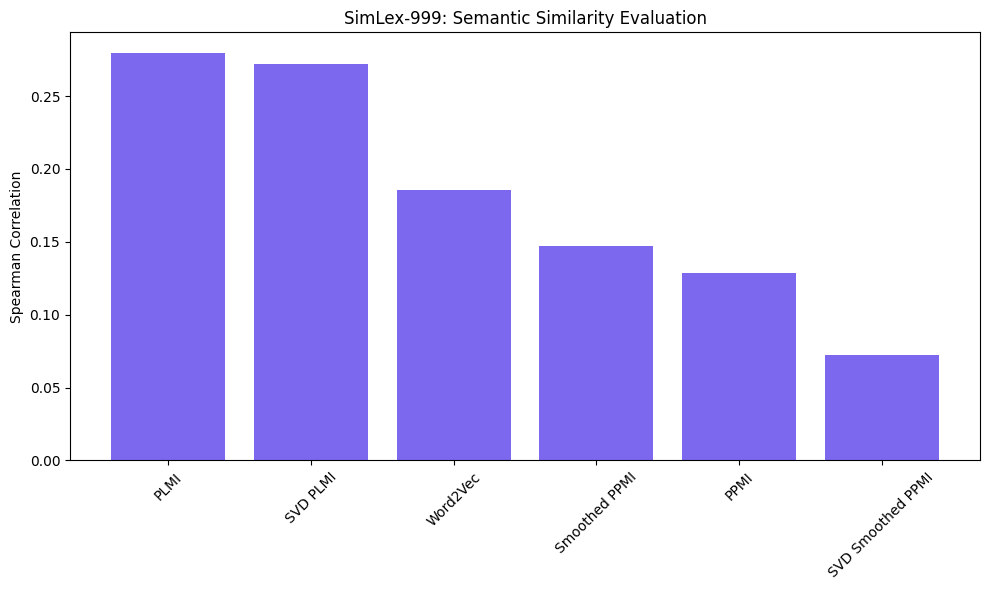

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(results_df["Model"], results_df["Spearman"], color="mediumslateblue")
plt.xticks(rotation=45)
plt.ylabel("Spearman Correlation")
plt.title("SimLex-999: Semantic Similarity Evaluation")
plt.tight_layout()
plt.show()

The best performing model in terms of semantic similarity was The PLMI model gave the best results overall, which shows that it was good at capturing word meaning. Its reduced version (SVD PLMI) also did well, meaning the dimensionality reduction didn’t hurt performance too much.

Word2Vec didn’t have the highest score, but it covered way more word pairs than the others. That’s useful in practice since it can handle a bigger vocabulary.

On the other hand, the smoothed PPMI models didn’t perform as well. Especially after applying SVD, the similarity scores got worse, probably because too much information was lost.

In short, PLMI gave the best results, and Word2Vec was a solid option thanks to its wide coverage.

For this assignment i was assisted by chat cpt, this is the link to the conversation: https://chatgpt.com/share/67e97df8-1b0c-800d-8a53-e5baf89cdc9b

---